<a href="https://colab.research.google.com/github/hyunicecream/Natural-Language-Processing-NLP-/blob/main/7/29_doc2vec_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-
"""6-15.doc2vec_train.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1fBkhIyIY_Auk9IeRp8Mef7OsctZkkmHa
"""

# Commented out IPython magic to ensure Python compatibility.
import numpy as np
import re
import pickle
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Dropout, Concatenate, Flatten, Average
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import math

# %cd '/content/drive/MyDrive/Colab Notebooks'

with open('/content/drive/MyDrive/머신러닝/Doc2vec/pv_dm_data.pkl', 'rb') as f:
    x_data, x_pv, x_seq, y_target, y_topic = pickle.load(f)

x_pv.shape, x_seq.shape, y_target.shape

((772630, 1), (772630, 9), (772630, 1))

In [ ]:
# PV-DM 모델을 생성한다.
doc_size = len(set(x_pv.reshape(-1)))
vocab_size = 20000
doc_dim = 400
LOAD_MODEL = True

if LOAD_MODEL:
    # 학습된 모델을 읽어온다.
    model = load_model("/content/drive/MyDrive/머신러닝/Doc2vec/pv_dm.h5") 
else:
    pv_input = Input(batch_shape = (None, 1))
    sq_input = Input(batch_shape = (None, 9))

    pv_emb = Embedding(doc_size, doc_dim, name='doc2vec')(pv_input) # (None, 1, 400)
    pv_emb = Flatten()(pv_emb)
    
    sq_emb = Embedding(vocab_size, doc_dim, name='word2vec')(sq_input) # (None, 9, 400)
    sq_emb = LSTM(doc_dim)(sq_emb)  # context의 흐름을 분석하려면 이렇게 한다. 2차원 구조(None, 400)
#   sq_emb = Flatten()(sq_emb)    # 논문 내용대로 구현하려면 위의 LSTM()대신 이렇게 한다.

    e_merge = Concatenate()([pv_emb, sq_emb])
    y_output = Dense(vocab_size, activation='softmax')(e_merge)

    model = Model([pv_input, sq_input], y_output)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
doc2vec (Embedding)             (None, 1, 400)       4275600     input_1[0][0]                    
__________________________________________________________________________________________________
word2vec (Embedding)            (None, 9, 400)       8000000     input_2[0][0]                    
______________________________________________________________________________________________

[0.05, 0.05, 0.025, 0.025, 0.025, 0.0125, 0.0125, 0.0125, 0.00625, 0.00625, 0.00625, 0.003125, 0.003125, 0.003125, 0.0015625, 0.0015625, 0.0015625, 0.001, 0.001, 0.001]


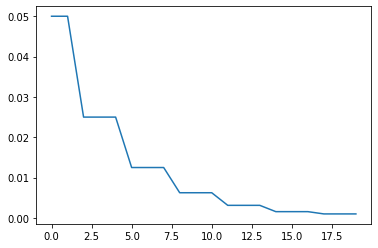

In [ ]:
# 학습할 때 epoch가 증가할 때마다 learning rate를 decay 시킨다.
def lr_decay(epoch):
    init_lr = 0.05
    min_lr = 0.001
    drop = 0.5
    epochs_drop = 3.0 # epoch 3번마다 0.05 준다.
    lr = init_lr * pow(drop, math.floor((1 + epoch) / epochs_drop))
    return max([lr, min_lr])

a = []
for i in np.arange(20):
    a.append(lr_decay(i))

plt.plot(a)
print(a)

In [ ]:
# 학습
l_rate = LearningRateScheduler(lr_decay, verbose=1)
hist = model.fit([x_pv, x_seq], y_target, batch_size=4096, epochs=50, callbacks = [l_rate])

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.05.
189/189 [==============================] - 38s 181ms/step - loss: 16.2910
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.05.
189/189 [==============================] - 34s 182ms/step - loss: 15.5484
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.025.
189/189 [==============================] - 34s 180ms/step - loss: 9.0796
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 0.025.
189/189 [==============================] - 34s 182ms/step - loss: 6.7869
Epoch 5/50

Epoch 00005: LearningRateScheduler reducing learning rate to 0.025.
189/189 [==============================] - 34s 180ms/step - loss: 6.2474
Epoch 6/50

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0125.
189/189 [==============================] - 34s 182ms/step - loss: 5.0663
Epoch 7/50

Epoch 00007: LearningRateScheduler reducing learning rate to 0.0125.


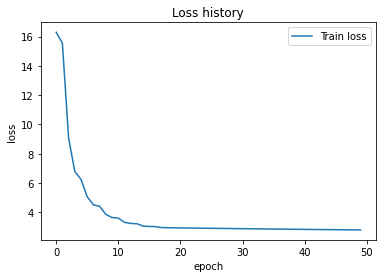

In [ ]:
# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [ ]:
# 학습 결과를 저장해 둔다.
model.save("/content/drive/MyDrive/머신러닝/Doc2vec/pv_dm.h5")

In [ ]:
# 모델에서 paragraph vector (D)와 word vector (W)를 읽어온다.
# emb의 내부 weights
D = model.get_layer('doc2vec').get_weights()[0]
W = model.get_layer('word2vec').get_weights()[0]
D.shape, W.shape

((10689, 400), (20000, 400))

In [ ]:
if D.shape[0] == len(y_topic):
    print('ok')

# paragraph vector (D)와 y_topic을 저장한다.
with open('/content/drive/MyDrive/머신러닝/Doc2vec/pv_dm_D.pkl', 'wb') as f:
    pickle.dump([x_data, D, np.array(y_topic).reshape(-1, 1)], f, pickle.DEFAULT_PROTOCOL)

ok
